In [1]:
import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras import models,layers,regularizers



try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns

print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.12.0


In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
train_zip = "/content/drive/MyDrive/LEVIR-CD/test.zip"
zip_ref = zipfile.ZipFile(train_zip, "r")
zip_ref.extractall("train.zip")
zip_ref.close()

In [4]:
val_zip = "/content/drive/MyDrive/LEVIR-CD/val.zip"
zip_ref = zipfile.ZipFile(val_zip, "r")
zip_ref.extractall("val.zip")
zip_ref.close()

In [5]:
test_zip = "/content/drive/MyDrive/LEVIR-CD/test.zip"
zip_ref = zipfile.ZipFile(train_zip, "r")
zip_ref.extractall("test.zip")
zip_ref.close()

In [6]:
# pixel labels in the video frames
class_names = ['change','no_change']

In [7]:
def concat_imgs(A,B):
    img=tf.concat([A,B],axis=2)
    #Images.append(img)
    return img

In [8]:
def map_filename_to_image_and_mask(A_filename, B_filename,Label_filename,height=128, width=128):
    """
      Preprocess the dataset by:
        * resizing the input image and the label map
        * normalizing the input_A image pixels ,input_B image pixels
        * concat input_A image with input_B image

      Args:
        A_filename (string) -- path to the first raw input image
        B_filename (string) -- path to the raw escond raw input image
        Label_filename (string) -- path to the raw annotation (label map) file
        
        height (int) -- height in pixels to resize to
        width (int) -- width in pixels to resize to

      Returns:
        image (tensor) -- preprocessed image
        annotation (tensor) -- preprocessed Label
      """
  
  # convert image and the mask file to tensor
    img_A_raw = tf.io.read_file(A_filename)
    img_B_raw = tf.io.read_file(B_filename)
    image_A = tf.image.decode_jpeg(img_A_raw)
    image_B = tf.image.decode_jpeg(img_B_raw)

    anno_raw = tf.io.read_file(Label_filename)
    annotation = tf.image.decode_jpeg(anno_raw)

    # Resize image and segmentation mask
    image_A = tf.image.resize(image_A, (height, width,))
    image_B = tf.image.resize(image_B, (height, width,))
    
    annotation = tf.image.resize(annotation, (height, width,))
    image_A = tf.reshape(image_A, (height, width, 3,))
    image_B = tf.reshape(image_B, (height, width, 3,))
    annotation = tf.cast(annotation, dtype=tf.float32)
    annotation=annotation//255
    annotation = tf.reshape(annotation, (height, width, 1,))
    
    
   
    # print(annotation)

    # Normalize pixels in the input image in range (-1,1)
    image_A = image_A/255
    image_A = (image_A - tf.reduce_min(image_A)) / (tf.reduce_max(image_A) - tf.reduce_min(image_A))
    image_A=2*image_A-1
    #image -= 1


    # Normalize pixels in the input image in range (-1,1)
    image_B = image_B/255
    image_B = (image_B - tf.reduce_min(image_B)) / (tf.reduce_max(image_B) - tf.reduce_min(image_B))
    image_B=2*image_B-1
    #image -= 1
    


    # concat
    image=concat_imgs(image_A,image_B)


    return image, annotation

In [9]:
def get_dataset_slice_paths(image_A_dir, image_B_dir, label_map_dir):
    '''
    generates the lists of image and label map paths

    Args:
    image_A_dir (string) -- path to the first input images directory
    image_B_dir (string) -- path to the second input images directory
    label_map_dir (string) -- path to the label map directory

    Returns:
    image_paths (list of strings) -- paths to each image file
    label_map_paths (list of strings) -- paths to each label map
    '''
    image_A_file_list = os.listdir(image_A_dir)
    image_B_file_list = os.listdir(image_B_dir)

    label_map_file_list = os.listdir(label_map_dir)
    image_A_paths = [os.path.join(image_A_dir, fname) for fname in image_A_file_list]
    image_B_paths = [os.path.join(image_B_dir, fname) for fname in image_B_file_list]

    label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_list]

    return image_A_paths,image_B_paths, label_map_paths

In [10]:
BATCH_SIZE = 64
def get_training_dataset(train_img_A_dir,train_img_B_dir, label_map_paths):
    '''
    Prepares shuffled batches of the training set.

    Args:
    train_img_A_dir (list of strings) -- paths to each image file in the A train set
    train_img_A_dir (list of strings) -- paths to each image file in the B train set
    label_map_paths (list of strings) -- paths to each label map in the train set

    Returns:
    tf Dataset containing the preprocessed train set
    '''
    training_dataset = tf.data.Dataset.from_tensor_slices((image_A_paths,image_B_paths, label_map_paths))
    training_dataset = training_dataset.map(map_filename_to_image_and_mask)
    training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True)
    training_dataset = training_dataset.batch(BATCH_SIZE)
    #training_dataset = training_dataset.repeat()
    #training_dataset = training_dataset.prefetch(-1)

    return training_dataset


def get_validation_dataset(val_img_A_dir,val_img_B_dir, Val_label_dir):
    '''
    Prepares batches of the validation set.

    Args:
    val_img_A_dir (list of strings) -- paths to each image file in the A val set
    val_img_A_dir (list of strings) -- paths to each image file in the B val set
    label_map_paths (list of strings) -- paths to each label map in the val set

    Returns:
    tf Dataset containing the preprocessed validation set
    '''
    validation_dataset = tf.data.Dataset.from_tensor_slices((validation_image_A_paths,validation_image_B_paths, validation_label_map_paths))
    validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
    validation_dataset = validation_dataset.batch(BATCH_SIZE)
    #validation_dataset = validation_dataset.repeat()

    return validation_dataset

def get_test_dataset(test_img_A_dir,test_img_B_dir, test_label_dir):
  num_examples=len(os.listdir(Test_label_dir))

  image_A_paths,image_B_paths, label_map_paths =get_dataset_slice_paths(test_img_A_dir,test_img_B_dir, test_label_dir)
  images=[] 
  labels=[]
  for i in range(len(image_A_paths)):
    img,label=map_filename_to_image_and_mask(image_A_paths[i],image_B_paths[i], label_map_paths[i])
    images.append(img)
    labels.append(label)
  images=tf.data.Dataset.from_tensor_slices(images)
  images = images.batch(num_examples)

  labels=tf.data.Dataset.from_tensor_slices(labels)
  labels = labels.batch(num_examples)

  return  images, labels

In [11]:
base_dir='/content'
train_img_A_dir=os.path.join(base_dir,"train.zip/A")
train_img_B_dir=os.path.join(base_dir,"train.zip/B")
val_img_A_dir=os.path.join(base_dir,"val.zip/A")
val_img_B_dir=os.path.join(base_dir,"val.zip/B")

test_img_A_dir=os.path.join(base_dir,"test.zip/A")
test_img_B_dir=os.path.join(base_dir,"test.zip/B")

Train_label_dir=os.path.join(base_dir,"train.zip/label")
Val_label_dir=os.path.join(base_dir,"val.zip/label")
Test_label_dir=os.path.join(base_dir,"test.zip/label")

In [12]:
# get the paths to the images
image_A_paths,image_B_paths, label_map_paths=get_dataset_slice_paths(train_img_A_dir,train_img_B_dir,Train_label_dir)
validation_image_A_paths,validation_image_B_paths,validation_label_map_paths = get_dataset_slice_paths(val_img_A_dir,val_img_B_dir,Val_label_dir)
test_image_A_paths, test_image_B_paths, test_label_map_paths=get_dataset_slice_paths(test_img_A_dir,test_img_B_dir,Test_label_dir)

In [13]:
training_dataset=get_training_dataset(image_A_paths,image_B_paths,label_map_paths)
validation_dataset=get_validation_dataset(validation_image_A_paths,validation_image_B_paths,validation_label_map_paths)
test_imgs,test_label=get_test_dataset(test_img_A_dir,test_img_B_dir,Test_label_dir)

In [14]:
#Check Range of pixels 
for i in training_dataset.take(1):
  #plt.imshow(i[0])
  #plt.show()
  print(np.amax(i[0]))
  print(np.amin(i[0]))

1.0
-1.0


In [15]:
#Check Range of pixels of label 
for i in training_dataset.take(1):
  #plt.imshow(i[1])
  #plt.show()
  print(np.amax(i[1]))
  print(np.amin(i[1]))

1.0
0.0


<img src='https://drive.google.com/uc?export=view&id=1Gs9K3_8ZBn2_ntOtJL_-_ww4ZOgfyhrS' alt='unet'>

In [16]:
# Encoder Utilities

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  '''
  Adds 2 convolutional layers with the parameters passed to it

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    tensor of output features
  '''
  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
  
  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  '''
  Adds two convolutional blocks and then perform down sampling on output of convolutions.

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    f - the output features of the convolution block 
    p - the maxpooled features with dropout
  '''

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  '''
  This function defines the encoder or downsampling path.

  Args:
    inputs (tensor) -- batch of input images

  Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
  '''
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

### Bottleneck

In [17]:
def bottleneck(inputs):
  '''
  This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  '''
  
  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

<img src='https://drive.google.com/uc?export=view&id=1Ql5vdw6l88vxaHgk7VjcMc4vfyoWYx2w' alt='unet_decoder'>

In [18]:
def attention_block(gating,x ,inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    theta_x = tf.keras.layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)
    
    #gating = tf.keras.layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)

    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)

    concat_xg = tf.keras.layers.add([phi_g, theta_x])
    act_xg = tf.keras.layers.Activation('relu')(concat_xg)
    psi = tf.keras.layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = tf.keras.layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32
    #upsample_psi = tf.keras.layers.UpSampling2D(size=(2,2))(sigmoid_xg)

    #upsample_psi = expend_as(upsample_psi, shape_x[3])

    y = tf.keras.layers.multiply([upsample_psi, x])

    result = tf.keras.layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    #result_bn = layers.BatchNormalization()(result)
    return result

In [19]:
# Decoder Utilities

def decoder_block(inputs, conv_output_lowr,conv_output_hgier, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
    '''
    defines the one decoder block of the UNet

    Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    padding (string) -- "same" or "valid", tells if shape will be preserved by zero padding

    Returns:
    c (tensor) -- output features of the decoder block
    '''
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
    conv_output = attention_block(conv_output_lowr,conv_output_hgier,n_filters)
    
    
    
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters, kernel_size=3)

    return c


def decoder(inputs, convs,encoder_output, output_channels):
    '''
    Defines the decoder of the UNet chaining together 4 decoder blocks. 

    Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

    Returns:
    outputs (tensor) -- the pixel wise label map of the image
    '''
    #encoder_output=f5
  
    f1, f2, f3, f4 = convs

    c6 = decoder_block(inputs,encoder_output, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c7 = decoder_block(c6,f4,f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c8 = decoder_block(c7,f3,f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c9 = decoder_block(c8,f2,f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

    outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='sigmoid')(c9)

    return outputs

In [83]:
OUTPUT_CHANNELS = 1

def unet():
    '''
    Defines the UNet by connecting the encoder, bottleneck and decoder.
    '''

    # specify the input shape
    inputs = tf.keras.layers.Input(shape=(128, 128,6,))

    # feed the inputs to the encoder
    encoder_output, convs = encoder(inputs)

    # feed the encoder output to the bottleneck
    bottle_neck = bottleneck(encoder_output)

    # feed the bottleneck and encoder block outputs to the decoder
    # specify the number of classes via the `output_channels` argument
    outputs = decoder(bottle_neck, convs,encoder_output, output_channels=OUTPUT_CHANNELS)

    # create the model
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model

# instantiate the model
model = unet()

# see the resulting model architecture
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_210 (Conv2D)            (None, 128, 128, 64  3520        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 activation_156 (Activation)    (None, 128, 128, 64  0           ['conv2d_210[0][0]']             
                                )                                                           

##focal_loss

In [23]:
!pip install -q focal_loss
import numpy as np
import tensorflow as tf
from focal_loss import sparse_categorical_focal_loss

def focal_loss_2(y_true, y_pred):
    gamma = 2
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

##contrastive_loss

In [24]:
from tensorflow.keras import backend as K

def contrastive_loss(y_true, y_pred):
 margin = 0.4
 square_pred = K.square(y_pred)
 margin_square = K.square(K.maximum(margin - y_pred, 0))
 return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


In [25]:
from tensorflow.keras import backend as K

def weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        # Original binary crossentropy (see losses.py):
        # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

        # Calculate the binary crossentropy
        b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

In [113]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.002), loss= weighted_binary_crossentropy(0.10, 0.90),
              metrics=['accuracy'])

In [115]:
from keras.models import load_model

# Train your Keras model here
model.save('/content/drive/My Drive/my_model_Attintion_Unet_Chance_detiction_M_2.h5')  # creates a HDF5 file 'my_model.h5'


In [130]:
!mkdir -p '/content/drive/My Drive/my_project_path'
!touch '/content/drive/My Drive/my_project_path/custom_loss_functions.py'


In [131]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/my_project_path')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
# number of training images
#train_count = 367

train_count=len(image_A_paths)
# numer of validation images
#validation_count = 101
validation_count=len(validation_image_A_paths)
BATCH_SIZE = 64

EPOCHS = 100

#steps_per_epoch = train_count//BATCH_SIZE # BATCH_SIZE = 64
validation_steps = validation_count//BATCH_SIZE

In [100]:
import random
import numpy as np

np.random.seed(44)  # set the random seed to 123

model_history = model.fit(training_dataset,
                    epochs=EPOCHS,
                    #verbose=1,
                    shuffle= True,
                    #steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset
                    #validation_st n ceps=validation_steps
                    )

Epoch 1/100
2/2 [==============================] - 16s 5s/step - loss: 0.0274 - accuracy: 0.9243 - val_loss: 0.0331 - val_accuracy: 0.9619
Epoch 2/100
2/2 [==============================] - 15s 5s/step - loss: 0.0275 - accuracy: 0.9445 - val_loss: 0.0259 - val_accuracy: 0.9394
Epoch 3/100
2/2 [==============================] - 16s 6s/step - loss: 0.0281 - accuracy: 0.9182 - val_loss: 0.0375 - val_accuracy: 0.9667
Epoch 4/100
2/2 [==============================] - 16s 6s/step - loss: 0.0276 - accuracy: 0.9475 - val_loss: 0.0256 - val_accuracy: 0.9428
Epoch 5/100
2/2 [==============================] - 14s 6s/step - loss: 0.0275 - accuracy: 0.9236 - val_loss: 0.0345 - val_accuracy: 0.9663
Epoch 6/100
2/2 [==============================] - 14s 6s/step - loss: 0.0278 - accuracy: 0.9395 - val_loss: 0.0264 - val_accuracy: 0.9506
Epoch 7/100
2/2 [==============================] - 14s 6s/step - loss: 0.0267 - accuracy: 0.9369 - val_loss: 0.0314 - val_accuracy: 0.9616
Epoch 8/100
2/2 [==========

In [101]:
def plot_metrics(metric_name, title, ylim=5):
  '''plots a given metric from the model history'''
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
  plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

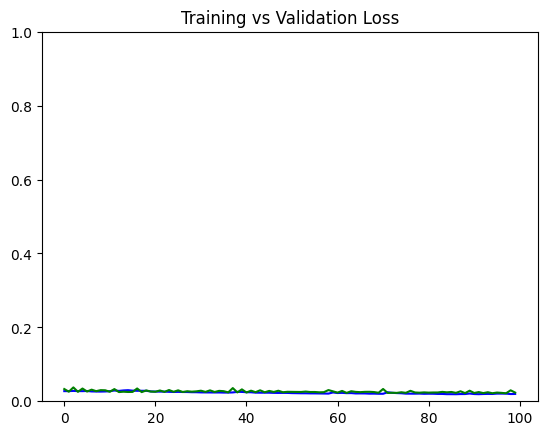

In [102]:
# Plot the training and validation loss
plot_metrics("loss", title="Training vs Validation Loss", ylim=1)

In [50]:
for i in training_dataset.take(1):
  #plt.imshow(i[0])
  #plt.show()
  print(np.amax(i[0]))
  print(np.amin(i[0]))

1.0
-1.0


In [103]:
predict=model.predict(test_imgs)

1/1 [==============================] - 0s 54ms/step


In [147]:
predict_55=l_model.predict(test_imgs)

1/1 [==============================] - 1s 895ms/step


In [34]:
predict.shape

(128, 128, 128, 1)

In [104]:
predict[:,:,:,:].min()

2.2920491e-20

In [157]:
predict[:,:,:,:].max()

0.999997

In [106]:
predict_2 = predict > 0.8
print (np.unique (predict_2))

[False  True]


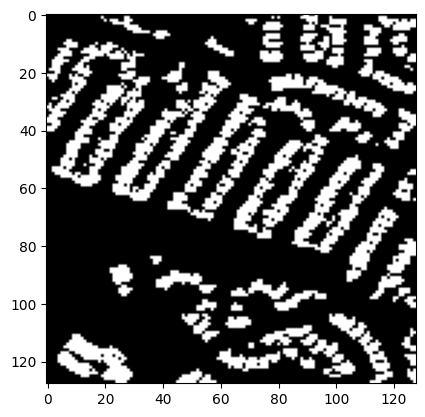

In [151]:
plt.imshow(predict_2[0,:,:,:]*255,cmap='gray')
plt.show()

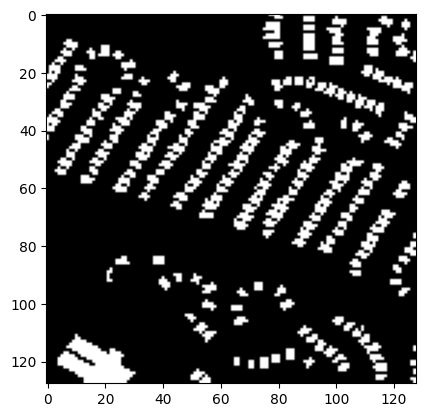

In [111]:
for i in test_label.take(1):
  plt.imshow(i[3,:,:,:],cmap='gray')
  plt.show()